In [43]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model initialisation

In [45]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [46]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob_list)

def mask_patches(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    feature_num = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, feature_num)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")


# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, sample_dim, reduction_dim, type='basic', patch_size=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.sample_dim = sample_dim
        self.H, self.W = sample_dim
        self.n = self.H * self.W
        self.p = reduction_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches(self.prob, self.patch_size, m, self.sample_dim).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [47]:
def train_loop(data_dict, model, criterion, optimizer, epochs=10, sample_average=20, record=True):
    if record:
      test_loss = []
      val_loss = []

    test_inputs = data_dict['test_inputs']
    test_targets = test_inputs

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            test_outputs = model(test_inputs)
            loss = criterion(test_outputs, test_targets)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          test_loss.append(loss_total.item())

          if epoch % (epochs//10) == 0:
              v_loss = test_loop(data_dict, model, criterion)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', test loss: ', loss.item(), ', val loss', v_loss)
          return {'test_loss': test_loss, 'val_loss': val_loss}

def test_loop(data_dict, model, criterion):
    val_inputs = data_dict['val_inputs']
    val_targets = val_inputs

    with torch.no_grad():
        val_outputs = model(val_inputs)
        loss = criterion(val_outputs, val_targets)
    return loss.item()

In [48]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion):
    test_inputs, test_targets, val_inputs, val_targets = data_dict.values()

    params_LAE = list(model_parameters)
    W1_LAE = params_LAE[0].clone().detach()
    fe_LAE_test_inputs = test_inputs @ W1_LAE.T
    fe_LAE_val_inputs = val_inputs @ W1_LAE.T
    
    fe_param = (torch.inverse(fe_LAE_test_inputs.T@fe_LAE_test_inputs) @ fe_LAE_test_inputs.T @ test_targets).T
    loss = criterion(val_targets, fe_LAE_val_inputs @ fe_param.T)
    return loss.item()

### Dataset

In [49]:
test_num = 80
val_num = 20
H = 8
W = 8
sample_dim = torch.tensor([H, W])
feature_num = H * W
reduction_dim = 3 * feature_num // 4
target_dim = feature_num // 2

prob = 0.75
prob_list = torch.rand(feature_num)*0.2 + 0.65
patch_size = torch.div(sample_dim, 4, rounding_mode='floor')

test_inputs = torch.rand(test_num, feature_num) * 2
test_inputs = test_inputs.to(device)
test_targets = torch.rand(test_num, target_dim)
test_targets = test_targets.to(device)
val_inputs = torch.rand(val_num, feature_num) * 2
val_inputs = val_inputs.to(device)
val_targets = torch.rand(val_num, target_dim)
val_targets = val_targets.to(device)
data_dict = {'test_inputs': test_inputs, 'test_targets': test_targets,
             'val_inputs': val_inputs, 'val_targets': val_targets}

fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [50]:
learning_rate = 0.001
epochs = 100
epochs_fe = 20

### Get features from autoencoder

##### Linear autoencoder

In [51]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(feature_num, reduction_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False)

    # feature extraction
    loss = feature_extraction(data_dict, net_LAE.parameters(), criterion)
    fe_loss_dict['LAE'].append(loss)

100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


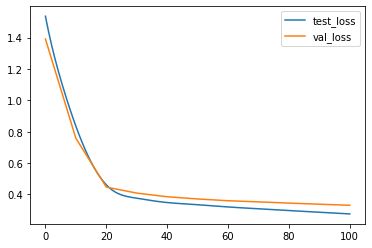

In [35]:
#plt.plot(loss_LAE['test_loss'])
#plt.plot(range(0, epochs+1, epochs//10), loss_LAE['val_loss'])
#plt.legend(loss_LAE.keys())

#del loss_LAE

##### Masked linear autoencoder (basic)

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, sample_dim, reduction_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False)

    # feature extraction
    loss = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion)
    fe_loss_dict['MLAE_basic'].append(loss)

epoch:  0 , test loss:  1.4796583652496338 , val loss 1.565111517906189
epoch:  800 , test loss:  0.3188694417476654 , val loss 0.3428457975387573
epoch:  1600 , test loss:  0.2572167217731476 , val loss 0.3093031048774719
epoch:  2400 , test loss:  0.2099088877439499 , val loss 0.2881769835948944
epoch:  3200 , test loss:  0.1831049621105194 , val loss 0.2633737027645111
epoch:  4000 , test loss:  0.1700122356414795 , val loss 0.2667396366596222
epoch:  4800 , test loss:  0.16348187625408173 , val loss 0.25329574942588806
epoch:  5600 , test loss:  0.16482487320899963 , val loss 0.26224181056022644
epoch:  6400 , test loss:  0.16299305856227875 , val loss 0.2577252686023712
epoch:  7200 , test loss:  0.1640927642583847 , val loss 0.2648032307624817
epoch:  8000 , test loss:  0.1567162722349167 , val loss 0.2416265457868576


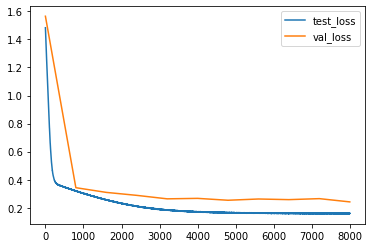

In [ ]:
#plt.plot(loss_MLAE_basic['test_loss'])
#plt.plot(range(0, epochs+1, epochs//10), loss_MLAE_basic['val_loss'])
#plt.legend(loss_MLAE_basic.keys())

#del loss_MLAE_basic

##### Masked linear autoencoder (probs)

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, sample_dim, reduction_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False)

    # feature extraction
    loss = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion)
    fe_loss_dict['MLAE_probs'].append(loss)

epoch:  0 , test loss:  1.5038460493087769 , val loss 1.5824023485183716
epoch:  800 , test loss:  0.3194000720977783 , val loss 0.34810325503349304
epoch:  1600 , test loss:  0.25665125250816345 , val loss 0.33064720034599304
epoch:  2400 , test loss:  0.21190623939037323 , val loss 0.29097220301628113
epoch:  3200 , test loss:  0.1831832230091095 , val loss 0.28441065549850464
epoch:  4000 , test loss:  0.17240086197853088 , val loss 0.2884592115879059
epoch:  4800 , test loss:  0.15461912751197815 , val loss 0.2516055107116699
epoch:  5600 , test loss:  0.15565697848796844 , val loss 0.27771714329719543
epoch:  6400 , test loss:  0.1616724580526352 , val loss 0.2656349837779999
epoch:  7200 , test loss:  0.16286829113960266 , val loss 0.2563447654247284
epoch:  8000 , test loss:  0.1594039648771286 , val loss 0.2515750527381897


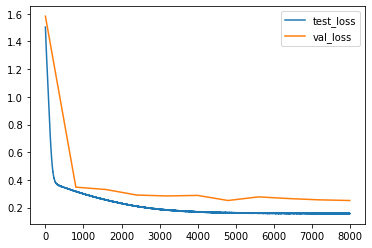

In [ ]:
#plt.plot(loss_MLAE_probs['test_loss'])
#plt.plot(range(0, epochs+1, epochs//10), loss_MLAE_probs['val_loss'])
#plt.legend(loss_MLAE_probs.keys())

#del loss_MLAE_probs

##### Masked linear autoencoder (patches)

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False)

    # feature extraction
    loss = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion)
    fe_loss_dict['MLAE_patches'].append(loss)

epoch:  0 , test loss:  1.4216854572296143 , val loss 1.504888892173767
epoch:  800 , test loss:  0.3250412940979004 , val loss 0.3429710268974304
epoch:  1600 , test loss:  0.2426687479019165 , val loss 0.3094867765903473
epoch:  2400 , test loss:  0.1918366402387619 , val loss 0.27287769317626953
epoch:  3200 , test loss:  0.17451351881027222 , val loss 0.25307223200798035
epoch:  4000 , test loss:  0.1420840322971344 , val loss 0.24776677787303925
epoch:  4800 , test loss:  0.13097360730171204 , val loss 0.22258853912353516
epoch:  5600 , test loss:  0.13127270340919495 , val loss 0.22927908599376678
epoch:  6400 , test loss:  0.11962411552667618 , val loss 0.2344290316104889
epoch:  7200 , test loss:  0.1248520165681839 , val loss 0.23362283408641815
epoch:  8000 , test loss:  0.12138654291629791 , val loss 0.24961557984352112


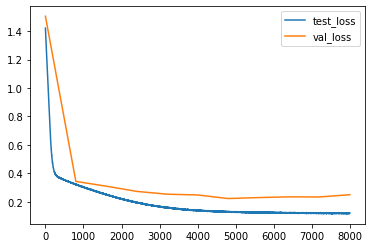

In [ ]:
#plt.plot(loss_MLAE_patches['test_loss'])
#plt.plot(range(0, epochs+1, epochs//10), loss_MLAE_patches['val_loss'])
#plt.legend(loss_MLAE_patches.keys())

#del loss_MLAE_patches

### Evaluation

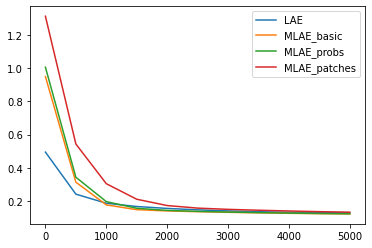

In [ ]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])